# Validation of ocean colour observations for harmful algal bloom application

Production Date: 15-11-2025  
Produced by: Chiara Volta (ENEA, Italy)

## 🌍 Use case: *Detection of harmful algal bloom*
## ❓ Quality assessment question
**How well do ocean colour observations detect *Karenia brevis* harmful bloom on the West Florida Shelf?**

The Ocean Colour dataset version 6.0, distributed by the Copernicus Climate Change Service (C3S), includes two variables: the chlorophyll-a mass concentration (chlor_a) and the remote sensing reflectance (Rrs) at six visible wavelengths, from October 1997 to the present [[1]](https://dast.copernicus-climate.eu/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf).  
Ocean colour observations have long supported the detection of algal blooms, enabling broader and more frequent coverage than in situ sampling [[2]](https://link.springer.com/chapter/10.1007/978-1-4020-3100-7_12) [[3]](https://doi.org/10.1016/j.ecolind.2025.113244). Moreover, these observations are becoming increasingly valuable for monitoring harmful algal blooms (HABs), toxic or excessive algal growth events that can cause ecological, economic, food security, and public health problems. While HABs are a global concern and are expected to increase worldwide in frequency, intensity and duration due to both climatic and non-climatic drivers (e.g., increasing temperature, higher nutrient inputs from river runoff) [[4]](https://www.ipcc.ch/srocc/chapter/chapter-5), they are particularly devastating in specific coastal regions. Consequently, substantial efforts have been made in recent years to integrate ocean colour data into forecasting systems to improve early warning capabilities [[5]](https://doi.org/10.1016/j.aquaculture.2024.741351).  
Here, the goal is to evaluate how accurately the Ocean Colour products can identify an HAB event. The focus is on the West Florida Shelf (WFS), an area where HABs of the toxic dinoflagellate *Karenia brevis* (*K. brevis*) have increased significantly in recent decades [[6]](https://doi.org/10.1016/j.hal.2006.08.005), causing severe damage to the regional ecosystem and economy [[7]](https://doi.org/10.1007/s10646-008-0241-x) [[8]](https://doi.org/10.1016/j.fishres.2020.105678) [[9]](https://doi.org/10.1016/j.jenvman.2023.119811).

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note

* The Ocean Colour dataset version 6.0 enables the calculation of two satellite-derived indicators that can be used to detect *Karenia brevis* bloom conditions on the West Florida Shelf: chlorophyll anomaly (chl_anom) and particulate backscattering ratio at 560 nm (bbp_560_ratio).

* The two satellite-derived indicators achieve an overall accuracy above 60% against *in situ* observations for both *Karenia brevis* blooms and non-blooms conditions, with bbp_560_ratio outperforming chl_anom.

* Sensitivity differs between the two indicators, with chl_anom more accurate in detecting *Karenia brevis* harmful blooms and bbp_560_ratio more accurate in detecting non-bloom waters.

* The two satellite-derived indicators capture the spatial distribution of *Karenia brevis* harmful blooms, although moderate events or areas affected by non-algal particles may be misclassified.

* The performance of the two indicators is strongly shaped by fixed thresholds, highlighting the need for regionally tuned or adaptive threshold strategies.

## 📋 Methodology

This notebook provides an assessment of the ability of the Ocean Colour dataset version 6.0 to identify the HABs of *K. brevis* on the WFS. A daily HAB event analysed in a previous study [[10]](https://doi.org/10.1016/j.hal.2022.102289) is used as test case.  
The analysis follows the approach described in [[11]](https://doi.org/10.1016/S1568-9883%2802%2900083-5) and [[12]](https://doi.org/10.1016/j.rse.2008.11.003), where chlor_a and Rrs at 560 nm data are used to calculate satellite-derived *K. brevis* HAB indicators: chlorophyll-a concentration anomaly (chl_anom) and total particulate backscattering ratio at 560 nm (bbp_560_ratio). The satellite-derived indicators are then compared with *in situ K. brevis* cell concentrations obtained from the Florida Fish and Wildlife Conservation Commission (FWC) Open Data portal to classify each pixel as a *K. brevis* bloom or non-bloom and to compute accuracy metrics that evaluate how effectively the satellite indicators detect bloom events.
 
The analysis and results are detailed in the sections below:

[](section-1)
   * Import libraries
   * Setup of satellite data requests

[](section-2)
   * Data retrieval and filtering
   * Computation of satellite-derived indicators of *K. brevis* HABs 
 
[](section-3)
   * Download data
   * Data filtering and subsetting

[](section-4)
   * Satellite and *in situ* data coupling
   * Accuracy metrics function
   * HAB/non-HAB classification and accuracy calculation
   * Functions for result visualisation

[](section-5)
   * Display results
   * Discussion

## 📈 Analysis and results
(section-1)=
### 1. Set up the code and choose the satellite data to use

#### Import libraries

Besides the standard libraries used for managing and visualising multidimensional arrays, the [C3S EQC custom function](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control) `c3s_eqc_automatic_quality_control` is imported to download satellite data. The `requests` and `datetime` modules are used to download and manage observed *K. brevis* cell concentrations from the FWC website, while  `Geod` and `confusion_matrix` are used to compare satellite and *in situ* data. 

In [90]:
from c3s_eqc_automatic_quality_control import download, utils
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import display, HTML
import requests
from datetime import datetime, timedelta
from pyproj import Geod
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

#### Setup of satellite data requests

The analysis in this notebook uses satellite-derived chlor_a and Rrs at 560 nm data acquired during the HAB of *K. brevis* identified on 14th July 2014 over the WFS by [[10]](https://doi.org/10.1016/j.hal.2022.102289), along with chlor_a data from the same area over the two-month period ending two weeks prior to the HAB event, which are required to calculate chlorophyll anomaly (see 'Computation of satellite-derived indicators of *K. brevis* HABs' section below). 

In [91]:
# Client configuration
os.environ["CDSAPI_RC"] = os.path.expanduser("~/calmanti_sandro/.cdsapirc")

# Define region
lon_slice = slice(-85.5, -81.5)
lat_slice = slice(27.5, 30.5)

# # Set satellite data requests
collection_id = "satellite-ocean-colour"

request_event = {
    "variable": ["mass_concentration_of_chlorophyll_a", "remote_sensing_reflectance"],
    "projection": "regular_latitude_longitude_grid",
    "year": ["2014"],
    "month": ["07"],
    "day": ["30"],
    "version": "6_0",
}
requests_event = [request_event]

request = {
    "variable": "mass_concentration_of_chlorophyll_a",
    "projection": "regular_latitude_longitude_grid",
    "version": "6_0",
}
date = "2014-07-30"
stop = pd.to_datetime(date) - pd.DateOffset(weeks=2)
start = stop - pd.DateOffset(months=2)
requests_sat = [
    request
    | {
        "year": date.strftime("%Y"),
        "month": date.strftime("%m"),
        "day": date.strftime("%d"),
    }
    for date in pd.date_range(start, stop)
]

(section-2)=
### 2. Satellite data retrieval and computation of satellite-derived indicators of HABs   
#### Data retrieval and filtering

Data for the daily HAB event and the two-month period required for the analysis are downloaded and organised into two separate datasets. Data are then filtered by retaining only measurements for which chlor_a falls within the valid range of 0.01–100 mg m<sup>-3</sup> [[13]](https://doi.org/10.3390/s19194285).

In [92]:
ds_event = download.download_and_transform(
    collection_id,
    requests_event,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lat_slice": lat_slice, "lon_slice": lon_slice},
    quiet=True,
)

ds = download.download_and_transform(
    collection_id,
    requests_sat,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lat_slice": lat_slice, "lon_slice": lon_slice},
    quiet=True,
)

#### Computation of satellite-derived indicators of *K. brevis* HABs 

Two satellite-derived *K. brevis* HAB indicators are computed: chl_anom and bbp_560_ratio.  
The chl_anom is calculated as the difference between chlor_a values from the satellite image acquired during the daily HAB event ([[10]](https://doi.org/10.1016/j.hal.2022.102289)) and the mean over two months ending two weeks prior to the image, as outlined in [[11]](https://doi.org/10.1016/S1568-9883%2802%2900083-5).  
The bbp_560_ratio is computed by adapting the equation for bbp ratio at 555 nm from [[12]](https://doi.org/10.1016/j.rse.2008.11.003). This approach relies on the same assumption made by [[12]](https://doi.org/10.1016/j.rse.2008.11.003), namely that the difference between Rrs at 555 nm and Rrs at 560 nm is negligible, and is motivated by the fact that Rrs at 555 nm is not available in the Ocean Colour dataset.

In [93]:
# Data filtering
ds_chl_event = ds_event["chlor_a"].where((ds_event["chlor_a"] > 1.0e-2) & (ds_event["chlor_a"] < 1.0e2))
ds_Rrs_560_event = ds_event["Rrs_560"].where((ds_event["chlor_a"] > 1.0e-2) & (ds_event["chlor_a"] < 1.0e2))
ds_chl = ds["chlor_a"].where((ds["chlor_a"] > 1.0e-2) & (ds["chlor_a"] < 1.0e2))

# chl_anom calculation
chl_anom = ds_chl_event - ds_chl.mean(dim="time")

# bbp_560_ratio calculation
bbp_560_ratio = (-0.00182 + (2.058*ds_Rrs_560_event)) / ((0.3*(ds_chl_event**0.62))*(0.002+0.02*(0.5-0.25*np.log10(ds_chl_event))))

(section-3)=
### 3. Download and extraction of *in situ K. brevis* cell concentrations
#### Download data

Historical *K. brevis* cell concentrations from the FWC Open Data portal are retrieved using the FWC REST API. All available records from 2007 to 2014 are downloaded in batches to account for API limits.

In [94]:
base_url = (
    "https://gis.myfwc.com/mapping/rest/services/Open_Data/"
    "Historic_Harmful_Algal_Bloom_Events_2007___2014/MapServer/6/query")

all_records = []
offset = 0
step = 2000

while True:
    params = {
        "where": "1=1",
        "outFields": "*",
        "f": "json",
        "resultOffset": offset,
        "resultRecordCount": step,
        "returnGeometry": "false",
    }
    r = requests.get(base_url, params=params)
    data = r.json()
    feats = data.get("features", [])
    if not feats:
        break
    all_records.extend([f["attributes"] for f in feats])
    offset += step

df = pd.DataFrame(all_records)
df["SAMPLE_DATE"] = pd.to_datetime(df["SAMPLE_DATE"], unit="ms")

#### Data filtering and subsetting

The FWC dataset is filtered to include only positive *K. brevis* cell counts collected at shallow depths (≤2 m) over the WFS region. The resulting subset is used for subsequent analysis.

In [95]:
lat_max = 30.5
lat_min = 27.5
lon_max = -81.5
lon_min = -85.5

latitude_min, latitude_max = lat_min, lat_max 
longitude_min, longitude_max = lon_min, lon_max 

mask = (
    (df["LATITUDE"].between(latitude_min, latitude_max)) &
    (df["LONGITUDE"].between(longitude_min, longitude_max)) &
    (df["DEPTH"] <= 2) &
    (df["COUNT_"] > 0)
)

df_filt = df.loc[mask].copy()

(section-4)=
### 4. Satellite and *in situ* data coupling, accuracy assessment, and result visualisation functions
#### Satellite and *in situ* data coupling

The `extract_satellite_values` function is used to pair *in situ* measurements with satellite-derived data. For each *in situ* sample collected within ±7 days of the satellite image date, the function identifies the nearest valid satellite pixel only if *in situ* location is within the spatial resolution of the Ocean Colour dataset (≈ 4km, [[1]](https://dast.copernicus-climate.eu/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf)) [[10]](https://doi.org/10.1016/j.hal.2022.102289). The resulting dataset contains only the coupled satellite–*in situ* pairs and is used for subsequent analysis of HAB indicators. 

In [222]:
# Function for satellite and in situ data coupling
geod = Geod(ellps="WGS84")   
def extract_satellite_values(chl_anom, bbp_560_ratio, df_filt):
    extracted = []
    lats = chl_anom["latitude"].values
    lons = chl_anom["longitude"].values
    times = chl_anom["time"].values
    for _, row in df_filt.iterrows():
        time_diff = np.abs(times - np.datetime64(row["SAMPLE_DATE"]))
        if time_diff.min() > np.timedelta64(pd.Timedelta("7D")):
            continue 
        nearest_time = times[time_diff.argmin()]       
        sub_chl = chl_anom.sel(time=nearest_time)
        sub_bbp = bbp_560_ratio.sel(time=nearest_time)
        lat2d, lon2d = np.meshgrid(lats, lons, indexing="ij")
        dist = np.empty_like(lat2d, dtype=float)
        for i in range(lat2d.shape[0]):
            for j in range(lat2d.shape[1]):
                _, _, d_m = geod.inv(row["LONGITUDE"], row["LATITUDE"], lon2d[i, j], lat2d[i, j])
                dist[i, j] = d_m / 1000 
        if dist.min() > 4.0:
            continue          
        i_min, j_min = np.unravel_index(dist.argmin(), dist.shape)
        chl_val = float(sub_chl.isel(latitude=i_min, longitude=j_min))
        bbp_val = float(sub_bbp.isel(latitude=i_min, longitude=j_min))
        if np.isnan(chl_val) or np.isnan(bbp_val):
            continue
        extracted.append({
            "date": row["SAMPLE_DATE"],
            "lat": row["LATITUDE"],
            "lon": row["LONGITUDE"],
            "cell_count": row["COUNT_"],
            "chl_anomaly": chl_val,
            "bbp_ratio": bbp_val
        })
    return pd.DataFrame(extracted)
    
# Satellite data extraction
merged = extract_satellite_values(chl_anom, bbp_560_ratio, df_filt)

#### Accuracy metrics function

The `accuracy_metrics` function computes accuracy statistics from paired *in situ* and satellite observations. For each satellite-derived indicator, the function extracts the number of true positives (TP) and true negatives (TN), which represent cases where satellite predictions and *in situ* observations agree; false positives (FP) when blooms are predicted but not observed *in situ*; and false negatives (FN) when blooms are observed *in situ*  but not predicted. From these values, the function calculates the accuracy in correctly identifying *in situ* blooms and non-blooms, following the method described in [[12]](https://doi.org/10.1016/j.rse.2008.11.003): HAB accuracy is defined as the proportion of correctly predicted blooms over the total number of HAB conditions (true and false) detected, while non-HAB accuracy represents the ratio between the number of non-HAB correctly predicted and the total number of non-HABs identified. The overall accuracy, defined as the proportion of correctly predicted data among all observations, is also provided. 

In [223]:
# Accuracy metrics function
def accuracy_metrics(df_filt, pred):
    tn, fp, fn, tp = confusion_matrix(df_filt, pred).ravel()
    user_bloom = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    user_nonbloom = tn / (tn + fn) if (tn + fn) > 0 else np.nan
    overall = (tp + tn) / (tp + tn + fp + fn)
    return user_bloom, user_nonbloom, overall

#### HAB/non-HAB classification and accuracy calculation

To classify *in situ* observations and satellite-derived indicators as bloom or non-bloom, the thresholds suggested by [[12]](https://doi.org/10.1016/j.rse.2008.11.003) are applied. An *in situ* sample is considered a *K. brevis* HAB if cell concentration is equal to or greater than 100000 cells/l. For the chl_anom and the bbp_560_ratio, values greater than 2 mg m⁻³ and lower than 2, respectively, are classified as *K. brevis* HABs. Based on this classification, each satellite-derived indicator is compared with the *in situ* data to quantify its ability to identify *K. brevis* HABs and non-HABs.

In [224]:
# Define thresholds
THRESHOLDS = {
    "cell_count": 100000, 
    "chl_anomaly": 2.0,  
    "bbp_ratio": 1.0}

# HAB/non-HAB classification
merged["obs_bloom"] = (merged["cell_count"] >= THRESHOLDS["cell_count"]).astype(int)
merged["sat_bloom_chl"] = (merged["chl_anomaly"] > THRESHOLDS["chl_anomaly"]).astype(int)
merged["sat_bloom_bbp"] = (merged["bbp_ratio"] < THRESHOLDS["bbp_ratio"]).astype(int)

# Computation of accuracy metrics for each satellite-derived indicator
results = {}
for alg in ["sat_bloom_chl", "sat_bloom_bbp"]:
    results[alg] = accuracy_metrics(merged["obs_bloom"], merged[alg])

#### Functions for result visualisation

The `print_confusion_details` function is used to summarise the number of true/false positives (TP/FP) and negatives (TN/FN) identified by the two satellite-derived indicators for table visualisation. The `classify_confusion` function is used to locate each paired *in situ*-satellite data point for map visualisation. See 'Display results' section below.

In [225]:
# Count confusion matrix elements
def print_confusion_details(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn, fp, fn, tp
tn_chl, fp_chl, fn_chl, tp_chl = print_confusion_details(merged["obs_bloom"], merged["sat_bloom_chl"])
tn_bbp, fp_bbp, fn_bbp, tp_bbp = print_confusion_details(merged["obs_bloom"], merged["sat_bloom_bbp"])

# Mapping
def classify_confusion(df, sat_col):
    conditions = [
        (df["obs_bloom"] == 0) & (df[sat_col] == 0),  # TN
        (df["obs_bloom"] == 0) & (df[sat_col] == 1),  # FP
        (df["obs_bloom"] == 1) & (df[sat_col] == 0),  # FN
        (df["obs_bloom"] == 1) & (df[sat_col] == 1),  # TP
    ]
    labels = ["TN", "FP", "FN", "TP"]
    df = df.copy()
    df[f"{sat_col}_confusion"] = np.select(conditions, labels, default="unknown")
    return df
merged_chl = classify_confusion(merged, "sat_bloom_chl")
merged_bbp = classify_confusion(merged, "sat_bloom_bbp")

(section-5)=
### 5. Display and discuss results
#### Display results

Two tables summarise the performance of the satellite-derived indicators against *in situ* observations. The first table indicate the number of true positives (TP), true negatives (TN), false positive (FP) and false negative (FN), as well as the total correctly and incorrectly classified observations and the total number of paired *in situ*-satellite observations. The second table reports the detection accuracies for each indicator, expressed as the percentage of correctly identified HABs and non-HABs, along with total accuracy.
Two maps are also provided to visually assess the spatial performance of each indicator. Here, *K. brevis* HABs observed *in situ* are overlaid on the chl_anom and bbp_560_ratio maps using coloured markers to indicate TP (green), FP (orange), TN (cyan) and FN (red).

,HAB detection accuracy (%),non-HAB detection accuracy (%),Total Accuracy (%)
Satellite-derived indicator:,,,
chl_anom,88,55,63
bbp_560_ratio,70,86,73


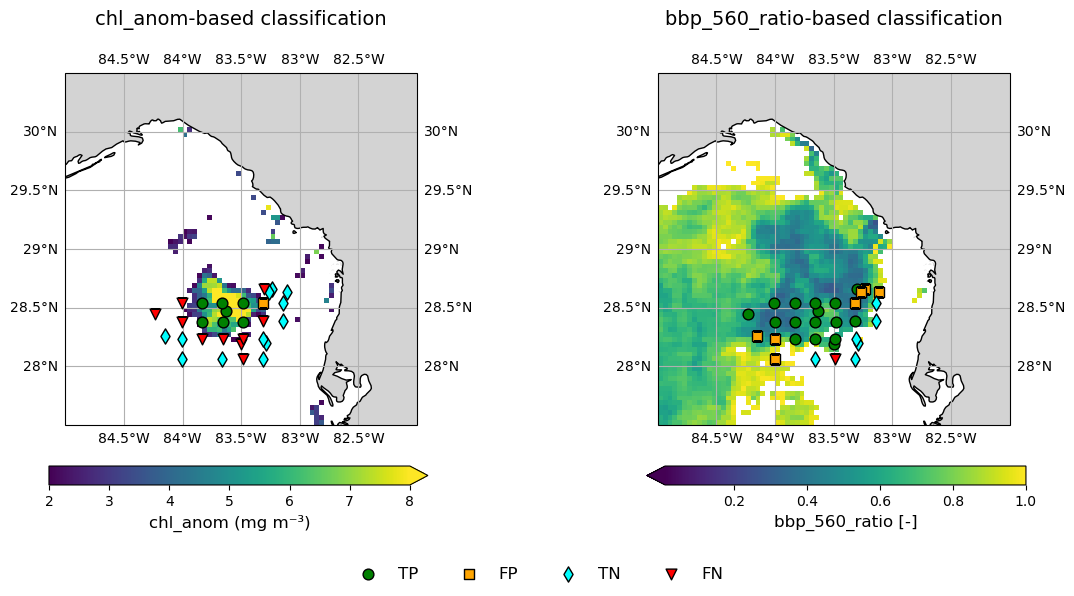

In [226]:
# Display table for confusion matrix elements
tn_chl, fp_chl, fn_chl, tp_chl = print_confusion_details(merged["obs_bloom"], merged["sat_bloom_chl"])
tn_bbp, fp_bbp, fn_bbp, tp_bbp = print_confusion_details(merged["obs_bloom"], merged["sat_bloom_bbp"])

rows = ["True Positive (TP)", "True Negative (TN)", "False Positive (FP)", "False Negative (FN)", "Correctly classified", "Incorrectly Classified", "Total"]
data = [
    [tp_chl, tp_bbp],
    [tn_chl, tn_bbp],
    [fp_chl, fp_bbp],
    [fn_chl, fn_bbp],
    [(tp_chl+tn_chl), (tp_bbp + tn_bbp)],
    [(fp_chl+fn_chl), (fp_bbp + fn_bbp)],
    [(tp_chl + tn_chl + fp_chl + fn_chl), (tp_bbp + tn_bbp + fp_bbp + fn_bbp)]
]
columns = pd.MultiIndex.from_tuples([
    ("Satellite-derived indicator (counts):", "chl_anom"),
    ("Satellite-derived indicator (counts):", "bbp_560_ratio")])
df = pd.DataFrame(data, index=rows, columns=columns)
styled_table = (
    df.style
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-size', '15px'), ('padding', '5px'), ('padding-right', '50px')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '15px'), ('padding', '5px'), ('padding-right', '50px')]},
        {'selector': 'tr:nth-child(5) th', 'props': [('border-top', '2px solid #cccccc')]},
        {'selector': 'tr:nth-child(5) td', 'props': [('border-top', '2px solid #cccccc')]},
        {'selector': 'tr:nth-child(1) th', 'props': [('border-top', '2px solid #cccccc')]},
        {'selector': 'tr:nth-child(1) td', 'props': [('border-top', '2px solid #cccccc')]},
        {'selector': 'tr:nth-child(7) th', 'props': [('border-top', '2px solid #cccccc')]},
        {'selector': 'tr:nth-child(7) td', 'props': [('border-top', '2px solid #cccccc')]},
        {'selector': 'tr:nth-child(7) th', 'props': [('border-bottom', '2px solid #cccccc')]},
        {'selector': 'tr:nth-child(7) td', 'props': [('border-bottom', '2px solid #cccccc')]}]))
display(styled_table)
display(HTML("<br><br><br>"))

# Display table for accuracy
table_data = []
alg_to_indicator = {"sat_bloom_chl": "chl_anom", "sat_bloom_bbp": "bbp_560_ratio"}
for alg, (ua_b, ua_nb, oa) in results.items():
    table_data.append({
        "Satellite-derived indicator:": alg_to_indicator[alg],
        "HAB detection accuracy (%)": f"{round(ua_b*100) if not pd.isna(ua_b) else 'NaN'}",
        "non-HAB detection accuracy (%)": f"{round(ua_nb*100) if not pd.isna(ua_nb) else 'NaN'}",
        "Total Accuracy (%)": f"{round(oa*100) if not pd.isna(oa) else 'NaN'}"})
accuracy_df = pd.DataFrame(table_data).set_index("Satellite-derived indicator:")
styled_accuracy_table = (
    accuracy_df.style
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-size', '15px'), ('padding', '10px')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '15px'), ('padding', '10px')]},
        {'selector': 'tr:nth-child(1)', 'props': [('background-color', '#f2f2f2')]}]))
display(styled_accuracy_table)
display(HTML("<br><br><br>"))

# Display maps
conf_colors = {
    "TP": "green", 
    "FP": "orange", 
    "TN": "cyan",
    "FN": "red"}

conf_markers = {
    "TP": "o",
    "FP": "s",
    "TN": "d",
    "FN": "v"}

# chl_anom-in situ data map
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax1 = axes[0]
im1 = (chl_anom.where(chl_anom > 2)).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    add_colorbar=False, vmin=2, vmax=8)
ax1.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
ax1.coastlines(resolution="10m")
ax1.set_extent([-85, -82, 27.5, 30.5], crs=ccrs.PlateCarree())
ax1.gridlines(draw_labels=True)
for label in ["TP", "FP", "TN", "FN"]:
    subset = merged_chl[merged_chl["sat_bloom_chl_confusion"] == label]
    ax1.scatter(
        subset["lon"], subset["lat"],
        color=conf_colors[label],
        marker=conf_markers[label],
        label=label,
        transform=ccrs.PlateCarree(),
        edgecolor="k",
        s=60,
        zorder=5)
ax1.set_title("chl_anom-based classification", fontsize=14, pad=20)
cbar1 = fig.colorbar(
    im1, ax=ax1, orientation="horizontal",
    fraction=0.046, pad=0.1, extend='max')
cbar1.set_label("chl_anom (mg m⁻³)", fontsize=12)

# bbp_560_ratio-in situ data map
ax2 = axes[1]
im2 = (bbp_560_ratio.where(bbp_560_ratio < 1)).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    add_colorbar=False, vmin=0.01, vmax=1)
ax2.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
ax2.coastlines(resolution="10m")
ax2.set_extent([-85, -82, 27.5, 30.5], crs=ccrs.PlateCarree())
ax2.gridlines(draw_labels=True)
for label in ["TP", "FP", "TN", "FN"]:
    subset = merged_bbp[merged_bbp["sat_bloom_bbp_confusion"] == label]
    ax2.scatter(
        subset["lon"], subset["lat"],
        color=conf_colors[label],
        marker=conf_markers[label],
        label=label,
        transform=ccrs.PlateCarree(),
        edgecolor="k",
        s=60,
        zorder=5)
ax2.set_title("bbp_560_ratio-based classification", fontsize=14, pad=20)
cbar2 = fig.colorbar(
    im2, ax=ax2, orientation="horizontal",
    fraction=0.046, pad=0.1, extend='min')
cbar2.set_label("bbp_560_ratio [-]", fontsize=12)

# Add common legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=4,
    fontsize=12,
    frameon=False)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()
plt.close()

#### Discussion

##### Chlorophyll anomaly (chl_anom)

Chl_anom achieves a total accuracy of 63%, correctly classifying 19 out of 30 paired *in situ*-satellite observations. Moreover, it correctly predicts 7 out of 9 *K. brevis* HABs observed *in situ* and 12 out of 22 observed non-HABs, resulting in HAB and non-HAB detection accuracy of 88% and 55%, respectively.  
The high HAB detection skill of chl_anom indicates that bloom conditions generally generate anomalies large enough to exceed the applied threshold, making this indicator sensitive to true *K. brevis* bloom events. However, results also reveal that some bloom-affected areas are misclassified as non-HABs of *K. brevis*, producing a relatively high number of false negatives. As shown in the classification map, these errors mainly occur near the edge of the bloom core, suggesting that moderate anomalies here may fall just below the chl_anom threshold applied.

##### Particulate backscattering ratio at 560 nm (bbp_560_ratio)

Bbp_560_ratio achieves a higher total accuracy of 73%, correctly classifying 22 out of 30 paired *in situ*-satellite observations. Specifically, it correctly identifies 16 out of 23 *K. brevis* HABs observed *in situ* and 6 out of 7 non-HAB cases, corresponding to HAB and non-HAB detection accuracy of 70% and 86%, respectively.  
The high non-HAB accuracy indicates that bbp_560_ratio effectively captures the optical signature of non-bloom waters, reducing false alarms. But, its lower HAB detection skill suggests that some *K. brevis* blooms do not produce a sufficiently strong reduction in backscattering, likely when *K. brevis* cells are mixed with non-algal particles or other phytoplankton species [[12]](https://doi.org/10.1016/j.rse.2008.11.003). However, its low false-negative rate highlights the potential value of this indicator for avoiding missed HAB events. 


Overall, this assessment demonstrates that both chl_anom and bbp_560_ratio provide valuable yet complementary capabilities for satellite-based *K. brevis* HAB detection and suggests that combining information from the two indicators could improve overall HAB detection and reduce misclassification errors. Nonetheless, the performance of both indicators appears strongly shaped by their reliance on fixed thresholds, highlighting the need for regionally tuned or adaptive thresholds strategies. Detection skill could be further enhanced by including hyperspectral satellite data to develop species- or region-specific algorithms and/or applying machine-learning approaches that integrate multiple optical and environmental variables [[14]](https://doi.org/10.3390/rs17040608) [[15]](https://doi.org/10.3390/rs13193863).

## ℹ️ If you want to know more

### Key resources
* CDS catalogue entry used in this notebook is the [Ocean colour daily data from 1997 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=overview)
* Data download is from [CDS](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=form)
* Product Documentation is available on the [CDS](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=documentation) website  

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [B-Open](https://www.bopen.eu/)

Further readings:
* Ocean Colour Monitoring Portals: [CMEMS](https://marine.copernicus.eu/), [ESA-GlobColour Project](https://hermes.acri.fr), [ESA-OC-CCI](https://climate.esa.int/en/projects/ocean-colour/), [ESA-Sentinel 3](https://sentiwiki.copernicus.eu/web/s3-mission), [IMOS](https://imos.org.au/facility/satellite-remote-sensing/ocean-colour), [NASA](https://oceancolor.gsfc.nasa.gov/#), [NOAA CoastWatch](https://coastwatch.noaa.gov/cwn/index.html).
* Use cases: [EUMETSAT](https://user.eumetsat.int/search-view?sort=startDate%20desc&facets=%7B%22theme%22:%5B%22Marine%7COcean%20biogeochemistry%22%5D,%22contentTypes%22:%5B%22Resources%7CCase%20studies%22%5D%7D), [C3S](https://climate.copernicus.eu/ocean).
* [International Ocean Colour Coordinating Group (IOCCG)](https://ioccg.org/).
* [Harmful Algae Event Database (HAEDAT)](https://haedat.iode.org/index.php).
* [Satellite product for detecting eutrophication and HAB events in the French-English Channel (S-3 EUROHAB)](https://www.s3eurohab.eu/#section-home)
* [NASA HAB forecasting system (HABOFS)](https://www.ncei.noaa.gov/products/nccos-harmful-algal-blooms-operational-forecasting-system)
* [Florida Fish and Wildlife Conservation Commission](https://myfwc.com).
* Groom, S., et al. (2019). [Satellite Ocean Colour: Current Status and Future Perspective](https://www.frontiersin.org/journals/marine-science/articles/10.3389/fmars.2019.00485/full). Frontiers in Marine Science, 6.
* IOCCG (2021). [Observation of Harmful Algal Blooms with Ocean Colour Radiometry](https://ioccg.org/wp-content/uploads/2021/05/ioccg_report_20-habs-2021-web.pdf). Bernard, S., et al. (eds.), IOCCG Report Series, No. 20, International Ocean Colour Coordinating Group, Darthmouth, Canada.

### References

[[1]](https://dast.copernicus-climate.eu/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf) Jackson, T., et al. (2023). C3S Ocean Colour Version 6.0: Product User Guide and Specification. Issue 1.1. E.U. Copernicus Climate Change Service. Document ref. WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product.   

[[2]](https://link.springer.com/chapter/10.1007/978-1-4020-3100-7_12) Stumpf, R.P., et al. (2007). Remote Sensing of Harmful Algal Blooms. In: Miller, R.L., et al. (eds.) Remote Sensing of Coastal Aquatic Environments. Remote Sensing and Digital Image Processing, vol. 7. Springer, Dordrecht, pp. 277-296.

[[3]](https://doi.org/10.1016/j.ecolind.2025.113244) Caballero, C.B., et al. (2025). The need for advancing algal bloom forecasting using remote sensing and modeling: Progress and future directions. Ecological Indicators, 172.

[[4]](https://www.ipcc.ch/srocc/chapter/chapter-5) Bindoff, N.L., et al. (2019). Changing Ocean, Marine Ecosystems, and Dependent Communities. In: IPCC Special Report on the Ocean and Cryosphere in a Changing Climate. H.-O. Pörtner, et al. (eds.). Cambridge University Press, Cambridge, UK and New York, NY, USA, pp. 447-587.

[[5]](https://doi.org/10.1016/j.aquaculture.2024.741351) Zahir, M., et al. (2024). A review on monitoring, forecasting, and early warning of harmful algal bloom. Aquaculture, 593, 741351.

[[6]](https://doi.org/10.1016/j.hal.2006.08.005) Brand, L.E., and Compton, A. (2007). Long-term increase in *Karenia brevis* abundance along the Southwest Florida Coast. Harmful Algae, 6(2), pp. 232-252.

[[7]](https://doi.org/10.1007/s10646-008-0241-x) Pierce, R.H., and Henry, M.S. (2008). Harmful algal toxins of the Florida red tide (*Karenia Brevis*): natural chemical stressors in South Florida coastal ecosystems. Ecotoxicology 17, pp. 623-631.

[[8]](https://doi.org/10.1016/j.fishres.2020.105678) Béchard, A. (2020). Economics losses to fishery and seafood related businesses during harmful algal blooms. Fisheries Research, 230.

[[9]](https://doi.org/10.1016/j.jenvman.2023.119811) Alvarez, S., et al. (2024). Non-linear impacts of harmful algae blooms on the coastal tourism economy. Journal of Environmental Management, 351.

[[10]](https://doi.org/10.1016/j.hal.2022.102289) Hu, C., et al. (2022). *Karenia Brevis* bloom patterns on the west Florida shelf between 2003 and 2019: Integration of Field and satellite observations. Harmful Algae, 17, 102289.

[[11]](https://doi.org/10.1016/S1568-9883%2802%2900083-5) Stumpf, R.P., et al. (2003). Monitoring *Karenia brevis* blooms in the Gulf of Mexico using satellite ocean colour imagery and other data. Harmful Algae, 2(2), pp. 147-160.

[[12]](https://doi.org/10.1016/j.rse.2008.11.003) Tomlinson, M.C., et al. (2009). An evaluation of remote sensing techniques for enhanced detection of the toxic dinoflagellate, *Karenia brevis*. Remote Sensing of Environment, 113(3), 598-609.

[[13]](https://doi.org/10.3390/s19194285) Sathyendranath, S., et al. (2019). An Ocean-Colour time series for use in climate studies: the experience of the Ocean-Colour Climate Change Initiative (OC-CCI). Sensors, 19, 4285.

[[14]](https://doi.org/10.3390/rs17040608) Arias et al. (2025). Mapping Harmful Algae Blooms: The Potential of Hyperspectral Imaging Technologies. Remote Sensing, 17(4), 608.

[[15]](https://doi.org/10.3390/rs13193863) Izadi et al. (2021). A Remote Sensing and Machine Learning-Based Approach to Forecast the Onset of Harmful Algal Bloom. Remote Sensing, 13(19), 3863.